In [1]:
# To get rid of those blocks of red warnings
import warnings
warnings.filterwarnings("ignore")

# Standard Imports
import numpy as np
from scipy import stats
import pandas as pd
from math import sqrt
import os
from sklearn.cluster import KMeans
import requests
import json
import time

# Vis Imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas.plotting import register_matplotlib_converters


# Modeling Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# Custom Module Imports
import wrangle

# Climate Change in Columbus, Ohio

<hr style="border-top:10px groove SpringGreen; margin-top: 2px; margin-bottom: 2px">

### Project Goal

- My goal is to analyze patterns in temperature in Columbus, Ohio and model those patterns to forecast temperature into the future.

<hr style="border-top:10px groove SpringGreen; margin-top: 2px; margin-bottom: 2px">

## Acquire and Prepare

<hr style="border-top:10px groove SpringGreen; margin-top: 2px; margin-bottom: 2px">

- The function acquire_df reads data from 2 seperate csv's and merges them using a left join.
- The function prepare_df converts the dates to datetime, renames the columns, removes nulls, sets the index, and splits the data.

In [2]:
# Reading the data from a csv
df = wrangle.acquire_df()

# Preparing and spliting the data into the train, validate, and test sets
df, train, validate, test = wrangle.prepare_df(df)

## Acquire and Prepare Takeaways
- I dropped all dates before the year 1850 as those contained the majority of the nulls in the dataset.
- I also dropped the year 2013 as it only had data up through September.
- I renamed dt to date to avoid issues referencing a keyword.

<hr style="border-top:10px groove SpringGreen; margin-top: 2px; margin-bottom: 2px">

## Explore Data

<hr style="border-top:10px groove SpringGreen; margin-top: 2px; margin-bottom: 2px">

### Is the Global Land Average Temperature related to the Average Temperature in Columbus, Ohio?

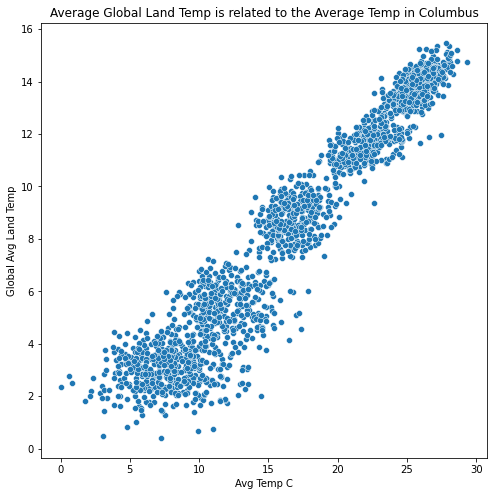

In [3]:
wrangle.vis_1(train)

### Scatterplot Takeaways
- There seems to be a high correlation between the Global Land Average Temperature and the Average Temperature in Columbus, Ohio.

___

### Stats Test for Scatterplot (SpearmanR)

Null - There is no relationship between the Global Land Average Temperature and the Average Temperature in Columbus, Ohio.

Alt - There is a relationship between the Global Land Average Temperature and the Average Temperature in Columbus, Ohio.

In [4]:
wrangle.stats_1(train)

Correlation: 0.9577062456035573
P-value: 0.0
We reject the null hypothesis that There is no relationship between the Global Land Average Temperature and the Average Temperature in Columbus, Ohio.
There is a relationship between the Global Land Average Temperature and the Average Temperature in Columbus, Ohio.


### Stats Test Takeaways
- There is in fact a relationship between the Global Land Average Temperature and the Average Temperature in Columbus, Ohio.

___

### What was the percentage of days throughout the years that were cold, cool, warm, and hot?

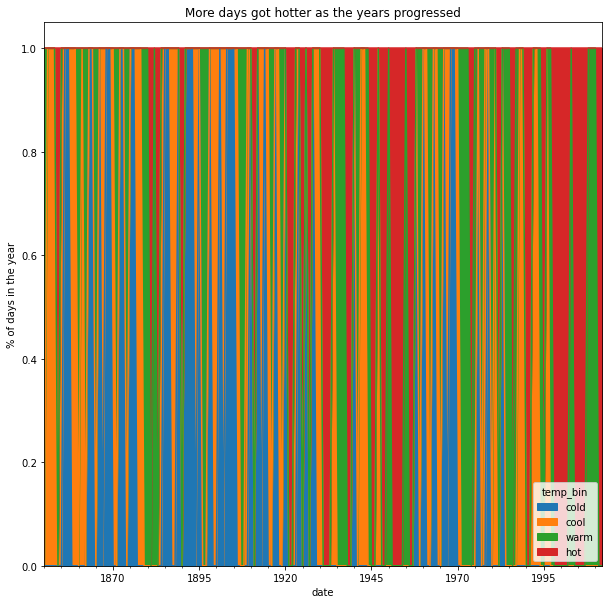

In [5]:
wrangle.vis_2(train)

### Area Chart Takeaways
- The percentage of days that were hot or warm increased as the years progressed. 

___


### Is the Global Land Average Temperature related to the Average Temperature in Columbus, Ohio?

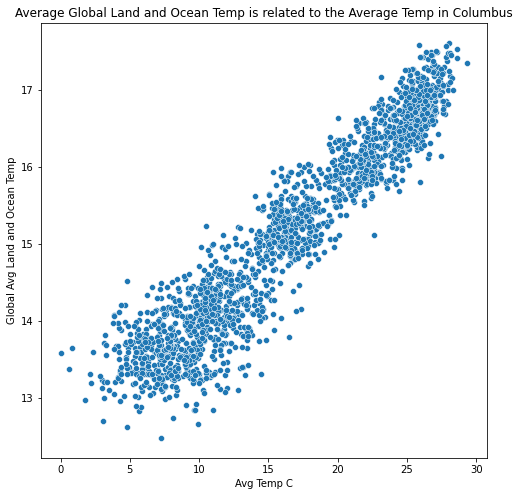

In [6]:
wrangle.vis_3(train)

### Scatterplot Takeaways
- There seems to be a high correlation between the Global Land and Ocean Average Temperature and the Average Temperature in Columbus, Ohio.

___

### Stats Test for Scatterplot (SpearmanR)

Null - There is no relationship between the Global Land and Ocean Average Temperature and the Average Temperature in Columbus, Ohio.

Alt - There is a relationship between the Global Land and Ocean Average Temperature and the Average Temperature in Columbus, Ohio.

In [7]:
wrangle.stats_3(train)

Correlation: 0.9463685307974817
P-value: 0.0
We reject the null hypothesis that There is no relationship between the Global Land and Ocean Average Temperature and the Average Temperature in Columbus, Ohio.
There is a relationship between the Global Land and Ocean Average Temperature and the Average Temperature in Columbus, Ohio.


### Stats Test Takeaways
- There is in fact a relationship between the Global Land and Ocean Average Temperature and the Average Temperature in Columbus, Ohio.

## Explore Takeaways
- There a relationship between the Global Land Average Temperature and the Average Temperature in Columbus, Ohio.
- The percentage of days that were hot or warm increased as the years progressed.
- There is a relationship between the Global Land and Ocean Average Temperature and the Average Temperature in Columbus, Ohio.

<hr style="border-top:10px groove SpringGreen; margin-top: 2px; margin-bottom: 2px">

## Model and Evaluate

<hr style="border-top:10px groove SpringGreen; margin-top: 2px; margin-bottom: 2px">

### Baseline RMSE

In [8]:
wrangle.baseline_rmse(train)

Baseline RMSE: 7.210407552440033


## Evaluate Top 3 models

In [13]:
train = train[['avg_temp']]
validate = validate[['avg_temp']]
test = test[['avg_temp']]
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [14]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Last Observed Value	

In [15]:
temp = round(train['avg_temp'][-1:][0], 2)

yhat_df = pd.DataFrame({'avg_temp': [temp]}, 
                       index = validate.index)
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,9.0


### Simple Average

In [16]:
temp = round(train['avg_temp'].mean(), 2)

yhat_df = pd.DataFrame({'avg_temp': [temp],}, index = validate.index)

for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,9.0
1,simple_average,avg_temp,11.0


### Previous Year

In [17]:
train = df[:'2010']
validate = df['2011']
test = df['2012':]
train = train[['avg_temp']]
validate = validate[['avg_temp']]
test = test[['avg_temp']]

In [18]:
yhat_df = train['2000'] + train.diff(365).mean()
pd.concat([yhat_df.head(1), validate.head(1)])

,avg_temp
date,
2000-01-01,7.20237
2011-01-01,4.86100


In [19]:
yhat_df.index = validate.index

for col in train.columns:
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,9.0
1,simple_average,avg_temp,11.0
2,previous year,avg_temp,3.0


### Model Takeaways
- My Previous Year model performed the best with a RMSE of 3.0

### Testing the best model (Previous Year)

In [20]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index
rmse_temp = round(sqrt(mean_squared_error(test['avg_temp'], yhat_df['avg_temp'])), 0)
print("Test RMSE - avg_temp: ", rmse_temp)

Test RMSE - avg_temp:  3.0


<hr style="border-top:10px groove SpringGreen; margin-top: 2px; margin-bottom: 2px">

## Conclusion

- There a relationship between the Global Land Average Temperature and the Average Temperature in Columbus, Ohio.
- The percentage of days that were hot or warm increased as the years progressed.
- There is a relationship between the Global Land and Ocean Average Temperature and the Average Temperature in Columbus, Ohio.
- Our RMSE beat baseline by around 57%

<hr style="border-top:10px groove SpringGreen; margin-top: 2px; margin-bottom: 2px">

## Next Steps
- If I had more time I would like to explore more modeling methods.
- I would also like to see is there is value using other cities to help the models performance.